In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Swiler's file paths for each dataset. 
gdp_data = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/GDP.csv', parse_dates=['DATE'])
cpat_tax = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/CPATAX.csv', parse_dates=['DATE'])
durable_goods = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/manufacturers_new_orders_durable_goods_excluding_defense.csv', parse_dates=['DATE'])
housing_starts = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/housing start.csv', parse_dates=['DATE'])
industrial_production = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/industrial_production_total_index.csv', parse_dates=['DATE'])
personal_consumption = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/PCECTPI.csv', parse_dates=['DATE'])
t10y2y = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/T10Y2Y.csv', parse_dates=['DATE'])
sp500_vix = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/sp500_vix_quarterly.csv', parse_dates=['Date'])
gtrend_recession = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/gtrend_recession.csv', parse_dates=['Month'])
gtrend_unemployment = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/gtrend_unemployment.csv', parse_dates=['Month'])
nonderiv_insider_activity = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/nonderiv_insider_activity.csv', parse_dates=['transactionDate'])

In [3]:
# Merge datasets on their respective date columns
data = gdp_data.copy()  # Start with GDP data

# Merge other datasets using 'DATE' or appropriate columns
data = data.merge(cpat_tax, on='DATE', how='left')
data = data.merge(durable_goods, on='DATE', how='left')
data = data.merge(housing_starts, on='DATE', how='left')
data = data.merge(industrial_production, on='DATE', how='left')
data = data.merge(personal_consumption, on='DATE', how='left')
data = data.merge(t10y2y, on='DATE', how='left')
data = data.merge(sp500_vix.rename(columns={'Date': 'DATE'}), on='DATE', how='left')
data = data.merge(gtrend_recession.rename(columns={'Month': 'DATE'}), on='DATE', how='left')
data = data.merge(gtrend_unemployment.rename(columns={'Month': 'DATE'}), on='DATE', how='left')
data = data.merge(nonderiv_insider_activity.rename(columns={'transactionDate': 'DATE'}), on='DATE', how='left')
print(data.head())

        DATE      GDP  CPATAX  ADXDNO  HOUST  IPB50001SQ  PCECTPI  T10Y2Y  \
0 1947-01-01  243.164   9.959     NaN    NaN     13.7361   11.557     NaN   
1 1947-04-01  245.968  13.603     NaN    NaN     13.7450   11.649     NaN   
2 1947-07-01  249.585  13.868     NaN    NaN     13.7719   11.866     NaN   
3 1947-10-01  259.745  14.455     NaN    NaN     14.1482   12.162     NaN   
4 1948-01-01  265.742  17.971     NaN    NaN     14.2916   12.297     NaN   

   S&P 500  VIX  recession: (United States)  \
0      NaN  NaN                         NaN   
1      NaN  NaN                         NaN   
2      NaN  NaN                         NaN   
3      NaN  NaN                         NaN   
4      NaN  NaN                         NaN   

   Unemployment benefits: (United States)  net_buys  
0                                     NaN       NaN  
1                                     NaN       NaN  
2                                     NaN       NaN  
3                                     

In [4]:
# Create a recession indicator based on a decline in GDP from one quarter to the next
data['GDP_diff'] = data['GDP'].diff()
data['Recession'] = np.where(data['GDP_diff'] < 0, 1, 0)

# Shift 'Recession' column by -1 to predict recession in the next quarter
data['Recession_next_quarter'] = data['Recession'].shift(-1)

# Drop rows with missing target values (for the last row where we can't predict the next quarter)
data.dropna(subset=['Recession_next_quarter'], inplace=True)

0     1947-01-01
1     1947-04-01
2     1947-07-01
3     1947-10-01
4     1948-01-01
         ...    
304   2023-01-01
305   2023-04-01
306   2023-07-01
307   2023-10-01
308   2024-01-01
Name: DATE, Length: 309, dtype: datetime64[ns]
180   1992-01-01
181   1992-04-01
182   1992-07-01
183   1992-10-01
184   1993-01-01
         ...    
304   2023-01-01
305   2023-04-01
306   2023-07-01
307   2023-10-01
308   2024-01-01
Name: DATE, Length: 129, dtype: datetime64[ns]
228   2004-01-01
229   2004-04-01
230   2004-07-01
231   2004-10-01
232   2005-01-01
         ...    
301   2022-04-01
302   2022-07-01
303   2022-10-01
304   2023-01-01
305   2023-04-01
Name: DATE, Length: 78, dtype: datetime64[ns]

Random Forest Model 1 Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        89
         1.0       0.25      0.25      0.25         4

    accuracy                           0.94        93
   macro avg       0.61      0.61     

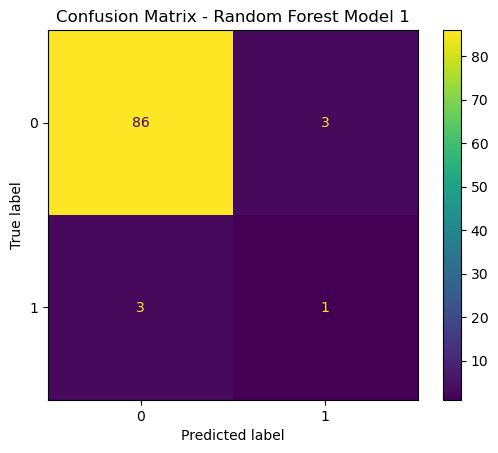

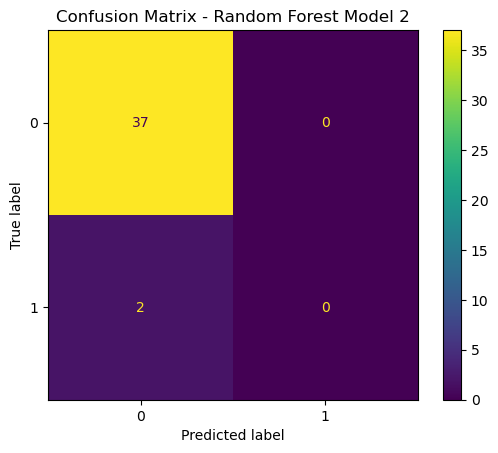

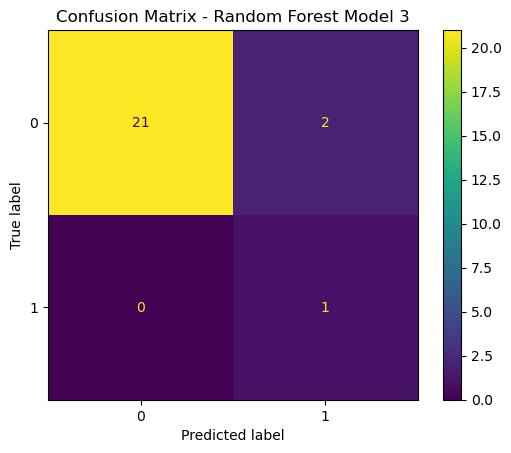

In [6]:
# Define the three different versions of X with different sets of variables
X_model1 = data[['CPATAX', 'PCECTPI', 'IPB50001SQ']]  # Variables for model 1
X_model2 = data[['CPATAX', 'PCECTPI', 'IPB50001SQ', 'HOUST', 'ADXDNO', 'T10Y2Y', 'S&P 500']].dropna()  # Variables for model 2
X_model3 = data[['CPATAX', 'PCECTPI', 'IPB50001SQ', 'HOUST', 'ADXDNO', 'T10Y2Y', 'S&P 500', 'VIX', 
          'recession: (United States)', 'Unemployment benefits: (United States)', 'net_buys']].dropna()  # Variables for model 3

# Target variable remains the same
y = data['Recession_next_quarter']

# Drop rows with missing values from X and y for each model to ensure consistency

# Model 1
Xy_model1 = pd.concat([X_model1, y], axis=1).dropna()
X_model1_cleaned = Xy_model1.drop(columns=['Recession_next_quarter'])
y_model1_cleaned = Xy_model1['Recession_next_quarter']
# Get the dates corresponding to the non-NaN rows in X
dates = data.loc[Xy_model1.index, 'DATE']
print(dates)

# Model 2
Xy_model2 = pd.concat([X_model2, y], axis=1).dropna()
X_model2_cleaned = Xy_model2.drop(columns=['Recession_next_quarter'])
y_model2_cleaned = Xy_model2['Recession_next_quarter']
# Get the dates corresponding to the non-NaN rows in X
dates = data.loc[Xy_model2.index, 'DATE']
print(dates)

# Model 3
Xy_model3 = pd.concat([X_model3, y], axis=1).dropna()
X_model3_cleaned = Xy_model3.drop(columns=['Recession_next_quarter'])
y_model3_cleaned = Xy_model3['Recession_next_quarter']
# Get the dates corresponding to the non-NaN rows in X
dates = data.loc[Xy_model3.index, 'DATE']
print(dates)

# Scale the features for each model
scaler = StandardScaler()
X_model1_scaled = scaler.fit_transform(X_model1_cleaned)
X_model2_scaled = scaler.fit_transform(X_model2_cleaned)
X_model3_scaled = scaler.fit_transform(X_model3_cleaned)

# Split the data into train and test sets for each model (70% train, 30% test)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_model1_scaled, y_model1_cleaned, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_model2_scaled, y_model2_cleaned, test_size=0.3, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_model3_scaled, y_model3_cleaned, test_size=0.3, random_state=42)

# Train and predict using Random Forest for each model
rf = RandomForestClassifier(n_estimators=5, class_weight='balanced', random_state=42)

# Model 1
rf.fit(X_train1, y_train1)
y_pred_model1_rf = rf.predict(X_test1)

# Model 2
rf.fit(X_train2, y_train2)
y_pred_model2_rf = rf.predict(X_test2)

# Model 3
rf.fit(X_train3, y_train3)
y_pred_model3_rf = rf.predict(X_test3)

# Model 1 evaluation
print("\nRandom Forest Model 1 Report (Test Set):\n", classification_report(y_test1, y_pred_model1_rf, zero_division=0))

# Model 2 evaluation
print("\nRandom Forest Model 2 Report (Test Set):\n", classification_report(y_test2, y_pred_model2_rf, zero_division=0))

# Model 3 evaluation
print("\nRandom Forest Model 3 Report (Test Set):\n", classification_report(y_test3, y_pred_model3_rf, zero_division=0))

# Confusion Matrix for Model 1
cm_model1 = confusion_matrix(y_test1, y_pred_model1_rf)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_model1)
disp1.plot()
plt.title("Confusion Matrix - Random Forest Model 1")
plt.show()

# Confusion Matrix for Model 2
cm_model2 = confusion_matrix(y_test2, y_pred_model2_rf)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_model2)
disp2.plot()
plt.title("Confusion Matrix - Random Forest Model 2")
plt.show()

# Confusion Matrix for Model 3
cm_model3 = confusion_matrix(y_test3, y_pred_model3_rf)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_model3)
disp3.plot()
plt.title("Confusion Matrix - Random Forest Model 3")
plt.show()